# Pathway Diagram Builder

This can help building a flux diagram of pathway more efficiently with the aid of Chemkin data or from cantera result. It could be seen as a complementary code for the mechanism analyzer, offering the result:

- The flux to important products from certain species

- The ratio of the flux between the reactant flux and a certain flux

--------------------------------------
## STEP 0: IMPORT MODULUS

In [1]:
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy.rmg.pdep import PDepReaction
from rmgpy.chemkin import loadChemkinFile, getSpeciesIdentifier
from rmgpy.tools.extractInfoFromckcsv import getConcentrationDictFromCKCSV, getROPFromCKCSV, getFluxGraphEdgesDict
from rmgpy.species import Species
from IPython.display import display, Image
import os
import numpy as np
from scipy.integrate import simps
import networkx as nx
import re
import pydot

# Needed for Cantera simulation
from rmgpy.tools.canteraModel import Cantera
from rmgpy.quantity import Quantity
import cantera as ct
from scipy import sparse

----------------------

## STEP 1: METHOD and FILEPATH INPUT 
#### Run Once per Mechanism Analyzed.

Supported Methodologies:

    - 'chemkin'
    - 'cantera'

Necessary Files (all methods): 

    - chemkin file (chem.inp)
    - species_dictionary.txt
    
Files Necessary for Chemkin Method:

    - chemkin simulation file (*.ckcsv)


Place these files under ./data/pathway_analysis/`mech` and input `mech` variable in the next cell.

In [3]:
########## User Input ##########
methodology = 'cantera'
mech = 'pdd'
################################

In [4]:
mechPath = os.path.join('./', 'data', 'pathway_analysis', mech)
chemkinPath= os.path.join(mechPath, 'chem.inp')
dictionaryPath = os.path.join(mechPath, 'species_dictionary.txt')

# extract the data to a RMG model
model = CoreEdgeReactionModel()
try:
    model.core.species, model.core.reactions = loadChemkinFile(chemkinPath, dictionaryPath, checkDuplicates=False)
except IOError:
    chemkinPath= os.path.join(mechPath, 'chem_annotated.inp')
    model.core.species, model.core.reactions = loadChemkinFile(chemkinPath, dictionaryPath, checkDuplicates=False)
# generate pairs for reactions that don't have flux pairs
for rxn in model.core.reactions:
    if not rxn.pairs: rxn.generatePairs()
        
if methodology == 'chemkin':
    # Abstract information from chemkin output
    ckcsvPath= mechPath + '/CKSoln.ckcsv'
    firstColDict, spc_mf_dict = getConcentrationDictFromCKCSV(ckcsvPath)
    first_col_dict, spc_total_rop_dict, spc_rop_dict = getROPFromCKCSV(ckcsvPath)
        
elif methodology == 'cantera':
    rmg_cantera_model = Cantera(speciesList=model.core.species, reactionList=model.core.reactions)
    rmg_cantera_model.loadModel()

# Create species_identifier_dict for the core species    
species_identifier_dict = {}
for i, s in enumerate(model.core.species):
    species_identifier_dict.update({getSpeciesIdentifier(model.core.species[i]): s})
    
# Create reaction_identifier_dict
rxn_identifier_dict = {}
for i, s in enumerate(model.core.reactions):
    rxn_identifier_dict.update({s.index:i})

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## HELPER TOOL (Optional)
### Species search

Run the following code to help determine the necessary species identifiers for the INPUT section. Support search by species index, species SMILES and species label in Chemkin file.

In [ ]:
############## User Input (optional) ##############
spc_index = 4
###################################################

spc = model.core.species[spc_index]
print 'The species identifier at index {0} is: {1}'.format(spc_index, getSpeciesIdentifier(spc))
display(spc)

In [ ]:
############## User Input (optional) ##############
species_smiles =  "C1C[C](O)CC1"
###################################################

if species_smiles:
    search_species = Species().fromSMILES(species_smiles)
    for key, key_item in species_identifier_dict.iteritems():
        if key_item.isIsomorphic(search_species):
            display(search_species)
            print 'has label as {0}'.format(key)
            species_smiles = None
            break
if species_smiles:
    print "Related species is not involved in the model."

In [ ]:
############## User Input (optional) ##############
species_label = 'C5H8O(684)'
###################################################

if species_label:
    try:
        display(species_identifier_dict[species_label])
        print "has label as {0}".format(species_label)
        
    except KeyError:
        print "The label is invalid."

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## STEP 2: CANTERA INPUT/SIMULATION
#### Run Once per Cantera Simulation / Time Point

This part is functioning when your methodology is 'cantera'.
- `reactor_type` the zero-dimensional Cantera reaction type with the following available options:
            * 'IdealGasReactor' (adiabatic, isochoric reactor)
            * 'IdealGasConstPressureReactor' (adiabatic, isobaric reactor)
            * 'IdealGasConstPressureTemperatureReactor' (isothermal, isobaric reactor)


- `reactor_time` the time point you want to investigate

- `mol_frac_list` a dictionary with species identifiers as keys and initial mole fractions as values

- `reactor_temp` the initial reactor temperature as an RMG Quantity object e.g. Quantity(value, unit_string)

- `reactor_pressure` the initial reactor pressure as an RMG Quantity object e.g. Quantity(value, unit_string)

- `integrated_flux` True if users want to use time-integrated fluxes (integrated up to the investigated time point) in kmol/kg_total for analysis. False if users want to use instantaneous fluxes in kmol/m3-s at the investigated time point for analysis

Warning: This part involves reaction simulation and may take some time

In [5]:
########################### User Input ###########################
reactor_type = 'IdealGasConstPressureTemperatureReactor'
reactor_time = Quantity(6*3600, 's')

mol_frac_list = {'PDD(1)':0.25,
                 'Toluene(2)':0.25,
                 'C11(36)':0.5,
                }

reactor_temp = Quantity(673, 'K')
reactor_pressure = Quantity(300, 'bar')
integrated_flux = True
##################################################################

In [6]:
solution = rmg_cantera_model.model # Cantera framework for thermo and kinetics data

# Set the reactor initial conditions
solution.TPX = reactor_temp.value_si, reactor_pressure.value_si, mol_frac_list
sparse_coefs = sparse.csr_matrix(solution.product_stoich_coeffs()) - sparse.csr_matrix(solution.reactant_stoich_coeffs()) # Stoichiometry matrix for ROP calcs

# Choose reactor
if reactor_type == 'IdealGasReactor':
    cantera_reactor = ct.IdealGasReactor(solution)
elif reactor_type == 'IdealGasConstPressureReactor':
    cantera_reactor = ct.IdealGasConstPressureReactor(contents=solution)
elif reactor_type == 'IdealGasConstPressureTemperatureReactor':
    cantera_reactor = ct.IdealGasConstPressureReactor(contents=solution, energy='off')
else:
    raise Exception('Other types of reactor conditions are currently not supported')
    
reactor_net = ct.ReactorNet([cantera_reactor])

# Run the Cantera simulation and calculate the ROPs
if integrated_flux: # sparse_rop is in kmol/kg_total for each reaction
    iteration = 0
    rop_iteration_modulus = 1 # Change if you want to "integrate" the rops less often (speed vs. accuracy trade-off)
    sparse_net_rates = sparse.diags(solution.net_rates_of_progress, format='csr')
    sparse_production_old = sparse_coefs.dot(sparse_net_rates)
    sparse_rops = sparse.csr_matrix(sparse_production_old.shape)
    volume = solution.volume_mass
    time = reactor_net.time
    
    while reactor_net.time < reactor_time.value_si:
        reactor_net.step()
        iteration += 1
        if iteration % rop_iteration_modulus == 0:
            sparse_net_rates = sparse.diags(solution.net_rates_of_progress, format='csr')
            sparse_production_new = sparse_coefs.dot(sparse_net_rates)
            sparse_rops += 0.5 * (sparse_production_new * solution.volume_mass + sparse_production_old * volume) * (reactor_net.time - time)
            volume = solution.volume_mass
            time = reactor_net.time
            sparse_production_old = sparse_production_new            
        
else: # sparse_rop is in kmol/m3-s
    reactor_net.advance(reactor_time.value_si)
    sparse_net_rates = sparse.diags(solution.net_rates_of_progress, format='csr')
    sparse_rops = sparse_coefs.dot(sparse_net_rates)
    time = reacto_time
    
# Build species and reactions matrix index key
cantera_species_matrix_index_dict ={}
for index, species in enumerate(solution.species()):
    cantera_species_matrix_index_dict.update({species.name: index})

# Read simulation condition for future use
timelist = time
T = solution.T
P = solution.P
V = solution.v
print "Investigated time point is {0} secs".format(timelist)

Investigated time point is 21635.7814443 secs


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## STEP 2: CHEMKIN INPUT 
#### Run Once per Chemkin Time Point

This part is functioning when methodology is 'chemkin' and does not involve any simulation

- `time_investigated` the time point or time scale (for integrated flux) you want to investigate. It will find the nearest time point in Chemkin simulation.
- `mol_frac_list` a dictionary with species identifiers as keys and initial mole fractions as values
- `integrated_flux` True if users want to use time-integrated fluxes (integrated up to the investigated time point) in mole for analysis. False if users want to use instantaneous fluxes in mole/cm3/s at the investigated time point for analysis

In [ ]:
########################### User Input ###########################
time_investigated = 0.004 # unit: second
mol_frac_list = {'CPO(1)':1,
}
integrated_flux = True
##################################################################

In [ ]:
timepoint_index = (np.abs(firstColDict['Time_(sec)']-time_investigated)).argmin()
timeList = firstColDict['Time_(sec)']
Plist = firstColDict['Pressure_(atm)']
Tlist = firstColDict['Temperature_(k)']
Vlist = firstColDict['Volume_(cm3)']
T = Tlist[timepoint_index]
P = Plist[timepoint_index]
print "Investigated time point is {0} secs".format(timeList[timepoint_index])


-------------

## STEP 3: GENERATE FLUX DIAGRAM
#### You can keep on modifying these parameters until getting desired flux diagram

- `spc_num_first_layer` the number of species, which have the largest fluxes from/to the species you want to look at of the first layer

- `spc_num_other_layer` same idea as `spc_num_first_layer`, but for other layers

- `pct_coverage` the percentage of the flux be covered from/to the species. 

- `pct_initial` the threshold to determine where the branches end

- `hierarchy` the number of layer to be built

- `reactant_basis` on what basis you want to calculate the flux ratio

- `preference` indicates the species you want to display in the diagram. 'carbon only' will exclude species without carbon atom. 'nitrogen only' will exclude species without nitrogen atom

- `png_name` is the .png file name you want to save as

In [7]:
########################### User Input ###########################
spc_num_first_layer = 100
spc_num_other_layer = 2
pct_coverage = 0.99
pct_initial = 0.015
hierarchy = 4
reactant_basis = 'PDD(1)'
preference = 'carbon only'
png_name = 'flux_rmg_pair_new.png'
##################################################################

In [8]:
# Create network
G = nx.DiGraph()

# Create production and consumption flux dictionary of each species
species_total_produce_flux_dict = {}
species_total_consume_flux_dict = {}

# generate paris for reactions that don't have flux pairs
for rxn in model.core.reactions:
    if not rxn.pairs: rxn.generatePairs()

for species_symbol, species in species_identifier_dict.iteritems():
    # Don't do anything for nonreactive species
    if species_symbol in ['He', 'Ne', 'Ar', 'N2']:
        continue
        
    # Initialize the dictionary
    species_total_produce_flux_dict.update({species_symbol: 0})
    species_total_consume_flux_dict.update({species_symbol: 0})
    
    if methodology == 'chemkin':
        rxn_rops_of_species = spc_rop_dict[species_symbol]
    elif methodology == 'cantera':
        rxn_rops_of_species = sparse_rops[cantera_species_matrix_index_dict[species_symbol],:].indices
    
    # Iterate all reaction in which the species involved
    for rxn_rop in rxn_rops_of_species:
        
        if methodology == 'chemkin':
            # Search for the reaction index from the table head 
            rxn_index_search = re.search('#[0-9]+_',rxn_rop[0])
            rxn_index = int(rxn_index_search.group()[1:-1])
            # Find the exact reaction in the core
            reaction = model.core.reactions[rxn_identifier_dict[rxn_index]]
            
            # Integrated flux or instananeous flux will be obtained for this reaction
            if integrated_flux: 
                flux = simps(rxn_rop[1][:timepoint_index+1],timeList[:timepoint_index+1],)
            else:
                flux = rxn_rop[1][timepoint_index]
            
        if methodology == 'cantera':
            rxn_index = rxn_rop
            reaction = model.core.reactions[rxn_index]
            flux = sparse_rops[cantera_species_matrix_index_dict[species_symbol], rxn_index]
            
        # Positive flux means produce species while negative flux means consume species
        if flux >= 0:
            species_total_produce_flux_dict[species_symbol] += flux
        else:
            species_total_consume_flux_dict[species_symbol] += -flux
            
            # Digraph is established here to avoid double counting issue
            for pair in reaction.pairs:
                if species in pair:
                    if species == pair[0]:
                        node = getSpeciesIdentifier(pair[1])
                    else:
                        node = getSpeciesIdentifier(pair[0])
                else:
                    continue
                
                if G.has_edge(species_symbol, node):                        
                    # Each edge of G has two properties, total flux and reaction list
                    G[species_symbol][node]['total_flux'] += -flux
                    G[species_symbol][node]['rxn'].append(reaction)
                else:
                    G.add_edge(species_symbol, node, total_flux = -flux, rxn = [reaction,])            

# Calculate the consumption of the indicated reactant
reactantConsumption = species_total_consume_flux_dict[reactant_basis]

In [9]:
from_species = True
species = reactant_basis
pct_coverage_default = pct_coverage

# Structure is a tree like list with each item containing the species in the corresponding layer
structure = [[species,],]
struct_dict = {species:0, }

# spc_involved will record what species have already showed up in this network
spc_involved = []

# DG is a smaller Digraph used to store the diagram information only
DG = nx.DiGraph()

# Generate the network layer by layer
level = 0
while level <= hierarchy:
    structure.append([])
    
    for current_node in structure[level]:     
        # If the species already be included, no need to look at its fluxes again
        if current_node in spc_involved:
            continue
        else:
            spc_involved.append(current_node)
            struct_dict[current_node] = level
            # if the network has already been extend to the desired level, no
            # need to look at as well
            if level == hierarchy:
                continue
                
        # No out flux from this species 
        if species_total_consume_flux_dict[current_node] == 0:
            continue
        
        # It is very important to extend the network as much as we can for
        # the first layer, otherwise we may lose track for important path
        if level ==0:
            pct_coverage = max(0.99, pct_coverage_default)
            spc_num = spc_num_first_layer
        else:
            pct_coverage = pct_coverage_default
            spc_num =spc_num_other_layer
        
        nextNode_flux_list = [(next_node, G[current_node][next_node]['total_flux']) for next_node in G[current_node]]
        sorted_flux_list = sorted(nextNode_flux_list, key=lambda tup: -tup[1])
        coverage = 0
        
        # The coverage calculation considering the repeated flux
        # e.g. A -> B + C, the flux_sum will include flux(A -> B)
        # as well as flux(A -> C)
        flux_sum_with_repeat = 0
        for item in sorted_flux_list:
            flux_sum_with_repeat += item[1]
        
        # Iterate each flux from large to small until reach the threshold of 
        # species number or 
        for index in range(spc_num):
            step_flux = sorted_flux_list[index][1]
            
            ## MODIFY
            ratio_initial_species = step_flux/reactantConsumption
            coverage += step_flux / flux_sum_with_repeat
                     
            # The out flux of the species is too small, makes the outfluxes of these species neglectable
            # if index == 0 and ratio_initial_species <= pct_initial:
            if ratio_initial_species <= pct_initial:
                break
            
            structure[level+1].append(sorted_flux_list[index][0])
            DG.add_edge(current_node, sorted_flux_list[index][0], flux = step_flux)

            # If coverage threshold is satisfied, we will look at next species of this layer
            if coverage >= pct_coverage:
                break
        
    level +=1

### Postprocessing

In [10]:
# Create a forbidden list that species would not be shown in the diagram
forbidden = []
if preference == 'carbon only':
    for index in spc_involved:
        species = species_identifier_dict[index]
        if species.molecule[0].getNumAtoms(element='C') == 0:
            forbidden.append(index)
if preference == 'nitrogen only':
    for index in spc_involved:
        species = species_identifier_dict[index]
        if species.molecule[0].getNumAtoms(element='N') == 0:
            forbidden.append(index)

# Add important flux but across levels
for spc1 in spc_involved:
    for spc2 in spc_involved:
        if spc1 != spc2:
            if (not DG.has_edge(spc1, spc2)) and (G.has_edge(spc1, spc2)):
                imp_flux = G[spc1][spc2]['total_flux']
                if imp_flux/reactantConsumption > pct_initial and (imp_flux/species_total_consume_flux_dict[spc1] > 0.2 or \
                imp_flux/species_total_produce_flux_dict[spc2] > 0.2):
                    DG.add_edge(spc1, spc2, flux = imp_flux)

# Prune cycle edges
repeats = []
for edge in DG.edges().iteritems():
    if (edge[0][1], edge[0][0]) in DG.edges and ((edge[0][1], edge[0][0]) not in repeats):
        repeats.append(edge[0])

for edge in repeats:
    diff_edge = DG[edge[0]][edge[1]]['flux'] - DG[edge[1]][edge[0]]['flux']    
    level0 = struct_dict[edge[0]]
    level1 = struct_dict[edge[1]] 
    
    if abs(diff_edge) < 0.05 * min(DG[edge[0]][edge[1]]['flux'], DG[edge[1]][edge[0]]['flux']):
        if level0 >= level1:
            DG.remove_edge(edge[1], edge[0])
            DG[edge[0]][edge[1]]['flux'] = 'equil.'
        else:
            DG[edge[1]][edge[0]]['flux'] = 'equil.'
    elif (diff_edge > 0) and (level0 <= level1):
        DG.remove_edge(edge[1], edge[0])
        DG[edge[0]][edge[1]]['flux'] = diff_edge
    elif (diff_edge < 0) and (level1 <= level0):
        DG.remove_edge(edge[0], edge[1])
        DG[edge[1]][edge[0]]['flux'] = - diff_edge
        
# Modify the initial flux
reactantConsumption = 0
for item in DG[reactant_basis]:
    reactantConsumption += DG[reactant_basis][item]['flux']
    


### Generate the flux diagram and save it as `flux.png` with pydot

In [32]:
# Basic Setting for this diagram
graph = pydot.Dot('flux_diagram', graph_type='digraph', overlap="false")
graph.set_rankdir('LR')
graph.set_fontname('sans')
graph.set_fontsize('10')

# Create a path to save the image of each species
speciesPath = mechPath +'/Species'
if not os.path.exists(speciesPath):
    os.mkdir(mechPath +'/Species')
    
# Add a node for each species
for index in spc_involved:
    species = species_identifier_dict[index]
    if index in forbidden:
        continue
    imagePath = os.path.join(os.path.abspath(mechPath), 'Species', '{0}.png'.format(index))
    with open(imagePath, 'w') as f:
        f.write(species._repr_png_())
    if os.path.exists(imagePath):
        if (index or index.upper() or index.lower() or index.title()) in mol_frac_list.keys():
            node = pydot.Node(name=index, shape='rectangle', fontcolor='transparent',\
                          image=imagePath, penwidth=2.5)
            print index
        else:
            node = pydot.Node(name=index, shape='rectangle', fontcolor='transparent',\
                          image=imagePath)
    else:
        node = pydot.Node(name=index, shape='rectangle')
    graph.add_node(node)
       
# Add an edge for each species-species rate
for reactantIndex, productIndex in DG.edges:
    if (reactantIndex in forbidden) or (productIndex in forbidden):
        continue
    reactant = species_identifier_dict[reactantIndex]
    product = species_identifier_dict[productIndex]
    edge = pydot.Edge(reactantIndex, productIndex)
    if type(DG[reactantIndex][productIndex]['flux']) == str:
        edge.set_label("equil.")
    else:
        edge_flux = DG[reactantIndex][productIndex]['flux']/reactantConsumption * 100
        edge.set_label("{0:.2f}%".format(edge_flux))
    graph.add_edge(edge)

    
# Generate the coordinates for all of the nodes using the specified program
program = 'dot'     
graph = pydot.graph_from_dot_data(graph.create_dot(prog=program))[0]

graph.write_png(os.path.join(mechPath, png_name))

PDD(1)
C11(36)


In [36]:
for index in spc_involved:
    if (index or index.upper() or index.lower() or index.title()) in mol_frac_list.keys():
        print index

(spc_involved[27].upper() or spc_involved[27].lower() or spc_involved[27].title()) in mol_frac_list.keys()

PDD(1)
C11(36)


'TOLUENE(2)'

### Display the flux diagram
hint: double click the image to zoom in/out, you can also find it in the `mech` path

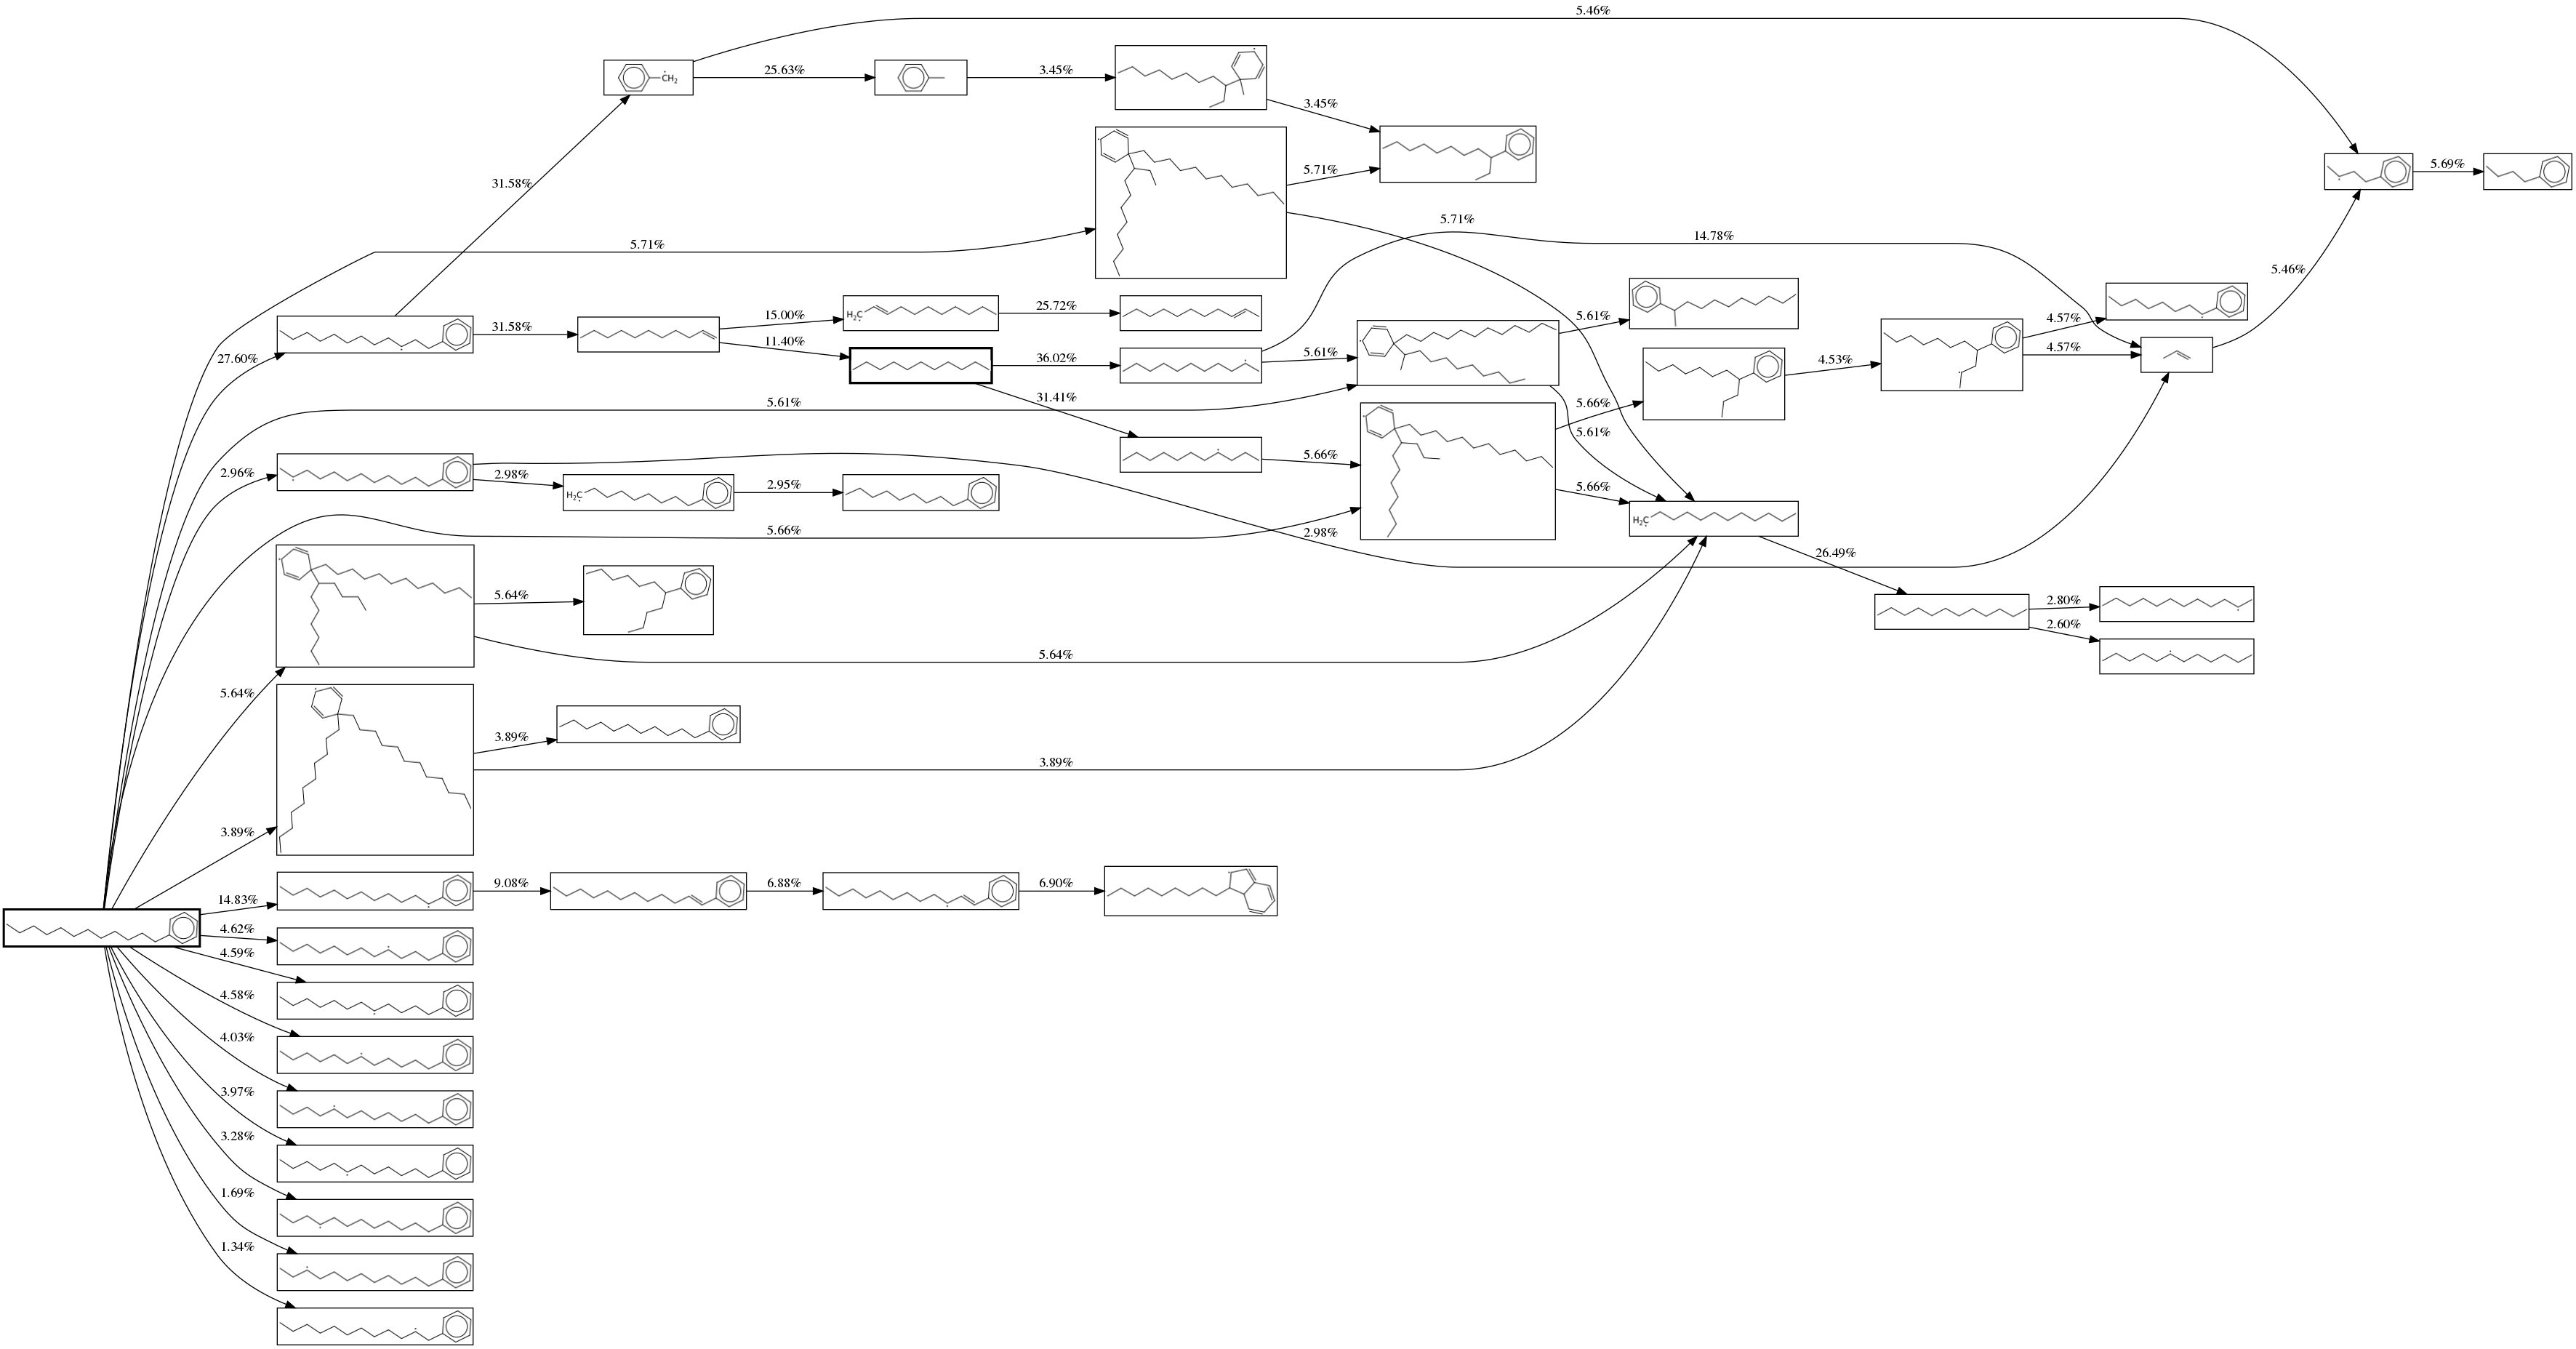

In [12]:
Image(filename=os.path.join(mechPath, png_name))

------

## STEP 4： find the reaction on the pathway

### Search for species (Optional)

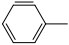

has label as 'TOLUENE(2)'


In [16]:
############## User Input (optional) ##############
species_smiles =  "c1ccccc1C"
###################################################

if species_smiles:
    search_species = Species().fromSMILES(species_smiles)
    for key, key_item in species_identifier_dict.iteritems():
        if key_item.isIsomorphic(search_species):
            display(search_species)
            print "has label as \'{0}\'".format(key)
            species_smiles = None
            break
if species_smiles:
    print "Related species is not involved in the model."

- `from_species` the chemkin name of the species being consumed

- `to_species` the chemkin name of species being produced 

- `example_rxn_num` the number of example reactions to be shown. If the actual reaction amount is less than the indicated number, it will only show up to the actual amount

Duplicate reaction will not be shown


In [ ]:
########################### User Input ###########################
from_species = 'CPO(1)'
to_species = 'C2H4(37)'
example_rxn_num = 3
##################################################################

In [ ]:
reaction_list = G[from_species][to_species]['rxn']
last_rxn = None
for rxn_list_index, rxn in enumerate(reaction_list):
    print ''
    print "Example reaction: rxn#{0}".format(rxn.index)
    print rxn
    
    display(rxn)
    
    # Remove repeated reactions
    if last_rxn:
        if rxn.isIsomorphic(last_rxn):
            continue      
    
    # Unit
    if len(rxn.reactants) == 1:
        unit_f = '1/s'
    elif len(rxn.reactants) == 2:
        unit_f = 'cm3/mole/s'
    
    if len(rxn.products) == 1:
        unit_r = '1/s'
    elif len(rxn.products) == 2:
        unit_r = 'cm3/mole/s'
    
    # Display reaction rate coefficient
    if rxn.kinetics.isPressureDependent:
        print 'Forward rate coefficient at {0} K: {1:.2E} {2}'.\
        format(T, rxn.getRateCoefficient(T, P), unit_f)
        reverseRate = rxn.generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K: {1:.2E} {2}'.\
        format(T, reverseRate.getRateCoefficient(T, P), unit_r)
    else:
        print 'Forward rate coefficient at {0} K: {1:.2E} {2}'.\
        format(T, rxn.getRateCoefficient(T), unit_f)
        reverseRate = rxn.generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K: {1:.2E} {2}'.\
        format(T, reverseRate.getRateCoefficient(T), unit_r)
        
    if rxn_list_index >= (example_rxn_num - 1):
        break
    
    if rxn_list_index > 0:
        last_rxn = rxn

-----
## APPENDIX: FROM SPECIES or TO SPECIES (one layer search)

### INPUT 

- `from_species` the direction "from a species" (from_species = True) or "to a species" (from_species = False)

- `species` the chemkin name of the species

- `spc_num` the number of species, which have the largest fluxes from/to the species you want to look at

- `pct_coverage` the percentage of the flux be covered from/to the species. 

- `example_rxn_num` the number of example reactions to be shown

The number of output fluxes will be decided on both last criteria and only the smaller one will be reported

In [ ]:
########################### User Input ###########################
from_species = True
species = 'C15H29(20)'
spc_num = 20
pct_coverage = 0.999
example_rxn_num = 0
##################################################################

In [ ]:
if from_species:
    direction = "From"
    total_species_flux = species_total_consume_flux_dict[species]
else:
    direction = "To"
    total_species_flux = species_total_produce_flux_dict[species]
        
if integrated_flux:
    unit = "mole"   
else:
    unit = "mole/cm3/s"

print "At this moment, the reactant's total molar consumption is {0:.3E} {1}.".\
    format(reactantConsumption, unit)
print ''

if integrated_flux:
    print '{0} {1} given integrated flux'.format(direction, species)
else:
    print '{0} {1} given instantaneous flux'.format(direction , species)
print '======================================'
print 'You are trying to find the top {0} fluxes.'.format(spc_num)
print ''

if from_species:
    nextNode_flux_list = [(next_node, G[species][next_node]['total_flux']) for next_node in G[species]]
    sorted_flux_list = sorted(nextNode_flux_list, key=lambda tup: -tup[1])
else:
    prev_nodes = []
    for node1 in G:
        if species in G[node1]:
            prev_nodes.append(node1)
    prevNode_flux_list = [(prev_node, G[prev_node][species]['total_flux']) for prev_node in prev_nodes]
    sorted_flux_list = sorted(prevNode_flux_list, key=lambda tup: -tup[1])

print "The total flux {0} {1} is {2: .4E} {3}".format(direction, species, total_species_flux, unit)

coverage = 0
repeated_flux = 0
for item in sorted_flux_list:
    repeated_flux += item[1]

for index in range(spc_num):
    step_flux = sorted_flux_list[index][1]
    ratio_initial_species = step_flux / reactantConsumption
    coverage += step_flux / repeated_flux
    
    if from_species:
        species_pair = (species, sorted_flux_list[index][0])
    else:
        species_pair = (sorted_flux_list[index][0], species)
    
    print '************************************************************************'
    print "No.{0}".format(index + 1)
    print "{0} --> {1} \t\t {2:.3E} {3} \t {4:.3f}%".\
    format(species_pair[0], species_pair[1], step_flux, unit, ratio_initial_species*100)
    
    rxn_count = 0
    reaction_list = G[species_pair[0]][species_pair[1]]['rxn']
    for rxn in reaction_list:
        print ''
        print "Example reaction: rxn#{0}".format(rxn.index)
        print rxn
        display(rxn)
        
        if rxn.kinetics.isPressureDependent:
            print 'Forward rate coefficient at {0} K: {1:.2E} mole/cm3/s'.\
            format(T, rxn.getRateCoefficient(T, P))
            reverseRate = rxn.generateReverseRateCoefficient()
            print 'Reverse rate coefficient at {0} K: {1:.2E} mole/cm3/s'.\
            format(T, reverseRate.getRateCoefficient(T, P))
        else:
            print 'Forward rate coefficient at {0} K: {1:.2E} mole/cm3/s'.\
            format(T, rxn.getRateCoefficient(T))
            reverseRate = rxn.generateReverseRateCoefficient()
            print 'Reverse rate coefficient at {0} K: {1:.2E} mole/cm3/s'.\
            format(T, reverseRate.getRateCoefficient(T))
            
        rxn_count += 1
        if rxn_count >= example_rxn_num:
            break
            
    if coverage >= pct_coverage:
        print ""
        print "{0} major fluxes are found satisfying your coverage.".format(index+1)
        break